# Imported the necessary libraries

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_private_expanded.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/toxicity_individual_annotations.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/train.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/identity_individual_annotations.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import roc_curve, roc_auc_score, classification_report

# Creation of the training dataframe

In [3]:
train_df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv', usecols=['target', 'comment_text'])

Converting the target to 1 or 0

In [4]:
train_df['target_class'] = np.where(train_df['target'] >= 0.5, 1, 0)

Visualization of the target class

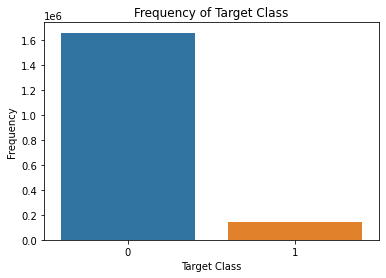

In [5]:
sns.countplot(data = train_df, x = 'target_class')
plt.xlabel('Target Class')
plt.ylabel('Frequency')
plt.title('Frequency of Target Class')
plt.show() 

# Cleaning of the text

In [6]:
train_clean = train_df

lemmatizer = WordNetLemmatizer()

def clean(sentence):
    sentence = sentence.replace('[0-9]','')
    sentence = sentence.lower()
    remove_list = stopwords.words("english")
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
    sentence = sentence.translate(translator)
    word_list = sentence.split()
    return ' '.join([lemmatizer.lemmatize(i) for i in word_list if i not in remove_list])
    
# cleaning

train_clean['comment_text_clean'] = train_clean['comment_text'].apply(lambda sentence : clean(sentence))     

# Applying TfidfVectorizer 

In [7]:
#parameters
toxicity_threshold = 0.2
n_gram = (1, 4)

#processing
texts = train_clean[train_clean['target'] > toxicity_threshold]['comment_text_clean']
tfidf = TfidfVectorizer(ngram_range=n_gram)
tfidf.fit_transform(texts)

<270194x16117220 sparse matrix of type '<class 'numpy.float64'>'
	with 26923326 stored elements in Compressed Sparse Row format>

# Creation of train_test_split of training data

In [8]:
X = tfidf.transform(train_clean['comment_text_clean'])
y = train_clean['target_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

# Applying Multinomial Naive Bayes 

AUC: 0.930


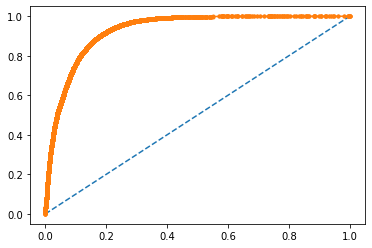

'              precision    recall  f1-score   support\n\n           0       0.92      1.00      0.96    166032\n           1       1.00      0.00      0.01     14456\n\n    accuracy                           0.92    180488\n   macro avg       0.96      0.50      0.48    180488\nweighted avg       0.93      0.92      0.88    180488\n'

In [9]:
naive = MultinomialNB()
naive.fit(X_train,y_train)

predictions = naive.predict_proba(X_test)
predictions = pd.DataFrame(predictions)

fpr, tpr, thresholds = roc_curve(y_test, predictions[1])
auc = roc_auc_score(y_test, predictions[1])
print('AUC: %.3f' % auc)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

classification_report(y_test, predictions[1]>0.5)

# Applying Logisitic Regression

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


AUC: 0.949


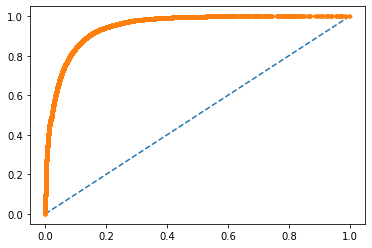

'              precision    recall  f1-score   support\n\n           0       0.95      0.99      0.97    166032\n           1       0.81      0.34      0.48     14456\n\n    accuracy                           0.94    180488\n   macro avg       0.88      0.66      0.72    180488\nweighted avg       0.93      0.94      0.93    180488\n'

In [10]:
logreg = LogisticRegression(C=2)
logreg.fit(X_train, y_train)
predictions = logreg.predict_proba(X_test)
predictions = pd.DataFrame(predictions)

fpr, tpr, thresholds = roc_curve(y_test, predictions[1])
auc = roc_auc_score(y_test, predictions[1])
print('AUC: %.3f' % auc)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

classification_report(y_test, predictions[1] > 0.5)

# Creation of the test dataframe and cleaning the text

In [11]:
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

#cleaning

test['comment_text_clean'] = test['comment_text'].apply(lambda sentence : clean(sentence)) ### to lower case

# Prediction and creating the submission file

In [12]:
test = tfidf.transform(test['comment_text_clean'])
submission =  logreg.predict_proba(test)
submission = pd.DataFrame(submission)
my_submission = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv')
my_submission = pd.merge(submission, my_submission, left_index=True, right_index=True)
my_submission = my_submission[['id', 1]].rename(columns={1 : 'prediction'})
my_submission.to_csv('submission.csv', index=False)